# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/'My Drive/Transsight/QSR'
%ls

Mounted at /content/drive
/content/drive/My Drive/Transsight/QSR
APC_Model.ipynb                   data/          RFM.ipynb
APC_TimeSeries_Experiments.ipynb  docs/
Churn_prediction.ipynb            QRS_EDA.ipynb


# Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# RFM Matrix

## Transaction data

In [3]:
trans_df = pd.read_csv("data/TransactionData - masked.csv")
trans_df['Transaction_date'] = pd.to_datetime(trans_df["Transaction Date"])
trans_df['Last_update_date'] = pd.to_datetime(trans_df["Last Update"])
print("Number of rows : ", len(trans_df))
print(f"Start date : {min(trans_df['Transaction_date']).date()} | End date : {max(trans_df['Transaction_date']).date()}")
trans_df.head(2)

Number of rows :  846369
Start date : 2018-05-01 | End date : 2018-06-30


,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount,Transaction_date,Last_update_date
0,386191,727585634,NaN,23 Jun 18,9821XXXX691,23 Jun 18,Dine In,2506,200.34,2018-06-23,2018-06-23
1,111063,721708340,MOHALI,8 Jun 18,9821XXXX718,8 Jun 18,Mobile App,7499,234.30,2018-06-08,2018-06-08


### Basic Info

#### Check basic info

##### Duplicates

In [ ]:
trans_df[trans_df.duplicated(keep=False)].head(4)

,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount,Transaction_date,Last_update_date


##### Zero or Negative amount data

In [4]:
trans_zero_df = trans_df.loc[trans_df.TotalAmount <= 0]
print('Ratio of data points have zero or negative value : ', len(trans_zero_df)/len(trans_df))
trans_zero_df.head(2)

Ratio of data points have zero or negative value :  0.00895590457590011


,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount,Transaction_date,Last_update_date
83,329030,726574557,BANGALORE,20 Jun 18,9821XXXX2605,20 Jun 18,Call center,1021,0.0,2018-06-20,2018-06-20
89,402369,727855362,COIMBATORE,24 Jun 18,9821XXXX2625,24 Jun 18,Zomato,2645,0.0,2018-06-24,2018-06-24


##### Null values

In [ ]:
count=trans_df.isnull().sum().sort_values(ascending=False)
ratio=count/len(trans_df)
pd.concat([count,ratio],axis=1,keys=['count','ratio'])

,count,ratio
city,605971,0.715965
channelId,3759,0.004441
Last_update_date,0,0.000000
Transaction_date,0,0.000000
TotalAmount,0,0.000000
CheckNo,0,0.000000
Last Update,0,0.000000
MobileNo,0,0.000000
Transaction Date,0,0.000000
GuestcheckId,0,0.000000


#### Drop unwanted rows

In [5]:
previous_data_size = len(trans_df)
trans_df = trans_df.loc[trans_df.TotalAmount > 0]

trans_df.drop('city', axis=1, inplace=True)
trans_df.dropna(inplace=True)
current_data_size = len(trans_df)

print('Number of dropped rows : ', previous_data_size - current_data_size)
print('Ratio of dropped rows : ', (previous_data_size - current_data_size)/previous_data_size)
print("Final data size : ", len(trans_df))

Number of dropped rows :  11293
Ratio of dropped rows :  0.013342879996786272
Final data size :  835076


#### Statistics

In [6]:
trans_df.describe()

,CustomerID,GuestcheckId,CheckNo,TotalAmount
count,835076.000000,8.350760e+05,835076.000000,835076.000000
mean,234995.836393,7.197597e+08,5402.115114,455.048116
std,141723.875622,6.952189e+06,2608.839553,408.419425
min,1.000000,7.065907e+08,1000.000000,0.140000
25%,114266.750000,7.137988e+08,3152.000000,229.900000
50%,229552.000000,7.207585e+08,5319.000000,390.280000
75%,344487.250000,7.256512e+08,7666.000000,572.260000
max,529567.000000,7.305051e+08,9999.000000,96894.900000


#### Unique values

In [7]:
trans_df.nunique()

CustomerID          514740
GuestcheckId        835076
Transaction Date        57
MobileNo            704236
Last Update             57
channelId               10
CheckNo               9000
TotalAmount          83138
Transaction_date        57
Last_update_date        57
dtype: int64

### Calculate Recency, Frequency and Monetary

In [ ]:
snapshot_date = trans_df['Transaction_date'].max() + timedelta(days=1)
print('Last date of the data : ', trans_df['Transaction_date'].max())
print('Reference date : ', snapshot_date)

data_process = trans_df.groupby(['CustomerID']).agg({
        'Transaction_date': lambda x: (snapshot_date - x.max()).days,
        'GuestcheckId': 'count',
        'TotalAmount': 'sum'})

data_process.rename(columns={'Transaction_date': 'Recency',
                         'GuestcheckId': 'Frequency',
                         'TotalAmount': 'Monetary'}, inplace=True)
data_process.head(2)

Last date of the data :  2018-06-30 00:00:00
Reference date :  2018-07-01 00:00:00


,Recency,Frequency,Monetary
CustomerID,,,
1,47,1,374.32
2,31,1,427.99


### Distribution of Recency, Frequency and Monetary

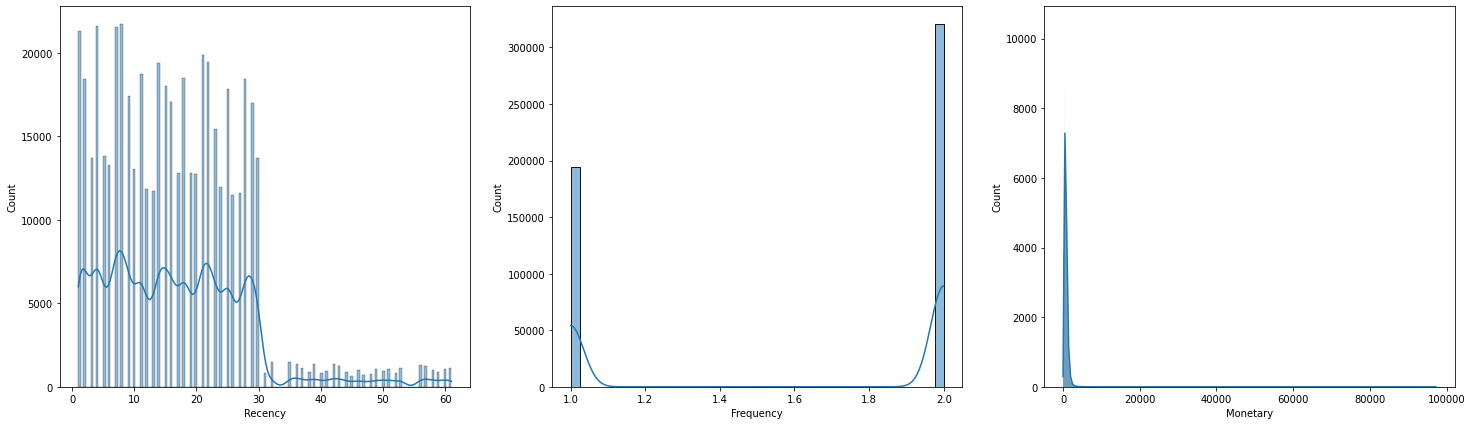

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

sns.histplot(data_process['Recency'], kde=True, ax=ax[0])

sns.histplot(data_process['Frequency'], kde=True, ax=ax[1])

sns.histplot(data_process['Monetary'], kde=True, ax=ax[2])

### Calculate Recency score, Frequency score and Monetary score

In [ ]:
data_process['R_score'] = 5 - pd.qcut(data_process['Recency'], 5, labels = False)
data_process['F_score'] = pd.qcut(data_process['Frequency'], 5, labels = False, duplicates='drop') + 1
data_process['M_score'] = pd.qcut(data_process['Monetary'], 5, labels = False) + 1
data_process.head(3)

,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
1,47,1,374.32,1,1,2
2,31,1,427.99,1,1,2
3,31,1,59.86,1,1,1


In [ ]:
data_process.R_score.unique(), data_process.F_score.unique(), data_process.M_score.unique()

(array([1, 2, 3, 4, 5]), array([1]), array([2, 1, 3, 5, 4]))

### RFM score and RFM categories

In [ ]:
data_process['RFM_score'] = data_process.R_score + data_process.F_score + data_process.M_score
data_process['RFM_category'] = data_process.R_score.astype(str) + data_process.F_score.astype(str) + data_process.M_score.astype(str)
data_process

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category
CustomerID,,,,,,,,
1,47,1,374.32,1,1,2,4,112
2,31,1,427.99,1,1,2,4,112
3,31,1,59.86,1,1,1,3,111
4,30,1,572.52,1,1,3,5,113
6,30,1,387.78,1,1,2,4,112
...,...,...,...,...,...,...,...,...
529562,1,1,302.72,5,1,1,7,511
529563,1,1,517.99,5,1,2,8,512
529565,1,1,117.78,5,1,1,7,511


#### Save file

In [ ]:
data_process.reset_index().to_csv('data/RFM_matrix.csv', index=False)

### Normalised Weighted RFM score

In [ ]:
data_process = pd.read_csv('data/RFM_matrix.csv')
data_process

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category
0,1,47,1,374.32,1,1,2,4,112
1,2,31,1,427.99,1,1,2,4,112
2,3,31,1,59.86,1,1,1,3,111
3,4,30,1,572.52,1,1,3,5,113
4,6,30,1,387.78,1,1,2,4,112
...,...,...,...,...,...,...,...,...,...
514735,529562,1,1,302.72,5,1,1,7,511
514736,529563,1,1,517.99,5,1,2,8,512
514737,529565,1,1,117.78,5,1,1,7,511
514738,529566,1,1,601.96,5,1,3,9,513


In [ ]:
data_process['N_R_score'] = data_process.R_score / data_process.R_score.max()
data_process['N_F_score'] = data_process.F_score / data_process.F_score.max()
data_process['N_M_score'] = data_process.M_score / data_process.M_score.max()
data_process.head(3)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category,N_R_score,N_F_score,N_M_score
0,1,47,1,374.32,1,1,2,4,112,0.2,1.0,0.4
1,2,31,1,427.99,1,1,2,4,112,0.2,1.0,0.4
2,3,31,1,59.86,1,1,1,3,111,0.2,1.0,0.2


In [ ]:
weights = [.35, .15, .50]

data_process['Weighted_RFM_score'] = data_process.N_R_score * weights[0] + data_process.N_F_score * weights[1] + data_process.N_M_score * weights[2]
data_process.head(3)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category,N_R_score,N_F_score,N_M_score,Weighted_RFM_score
0,1,47,1,374.32,1,1,2,4,112,0.2,1.0,0.4,0.42
1,2,31,1,427.99,1,1,2,4,112,0.2,1.0,0.4,0.42
2,3,31,1,59.86,1,1,1,3,111,0.2,1.0,0.2,0.32


### Segment customers based on Weighted Normalised score

In [ ]:
data_process["Labels"] = pd.qcut(data_process.Weighted_RFM_score, 5, labels=["lost customer", "probable churns", "low", "medium", "high"])
data_process

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category,N_R_score,N_F_score,N_M_score,Weighted_RFM_score,Labels
0,1,47,1,374.32,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer
1,2,31,1,427.99,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer
2,3,31,1,59.86,1,1,1,3,111,0.2,1.0,0.2,0.32,lost customer
3,4,30,1,572.52,1,1,3,5,113,0.2,1.0,0.6,0.52,lost customer
4,6,30,1,387.78,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514735,529562,1,1,302.72,5,1,1,7,511,1.0,1.0,0.2,0.60,probable churns
514736,529563,1,1,517.99,5,1,2,8,512,1.0,1.0,0.4,0.70,low
514737,529565,1,1,117.78,5,1,1,7,511,1.0,1.0,0.2,0.60,probable churns
514738,529566,1,1,601.96,5,1,3,9,513,1.0,1.0,0.6,0.80,medium


### Manually segmentated customers based on RFM categories

In [ ]:
rfm_seg_df = pd.read_csv('data/RFM_segmentation.csv')
rfm_seg_df.head(3)

,RFM_category,Interpreted_Sub_Labels,Interpreted_Labels,Number_of_users
0,511,Newcomers,New customers,56811
1,512,Newcomers,New customers,34878
2,315,Expecting better services but profitable,Need attention,29978


In [ ]:
data_process['Interpreted_Labels'] = data_process['RFM_category'].map(rfm_seg_df.set_index('RFM_category')['Interpreted_Labels'])
data_process['Interpreted_Sub_Labels'] = data_process['RFM_category'].map(rfm_seg_df.set_index('RFM_category')['Interpreted_Sub_Labels'])
data_process.head(3)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category,N_R_score,N_F_score,N_M_score,Weighted_RFM_score,Labels,Interpreted_Labels,Interpreted_Sub_Labels
0,1,47,1,374.32,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer,Lost customer,Lost is lost customer
1,2,31,1,427.99,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer,Lost customer,Lost is lost customer
2,3,31,1,59.86,1,1,1,3,111,0.2,1.0,0.2,0.32,lost customer,Lost customer,Lost is lost customer


#### Save file

In [ ]:
data_process.to_csv('data/Customer_Segmentation_using_RFM.csv', index=False)

### Customer segmentations plot

#### Based on weighted RFM score

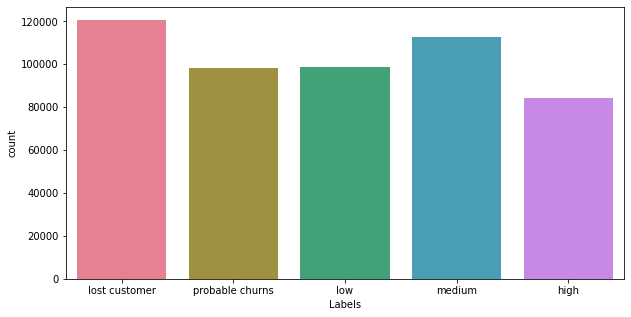

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Labels", data=data_process, palette="husl")

#### Based on RFM categories

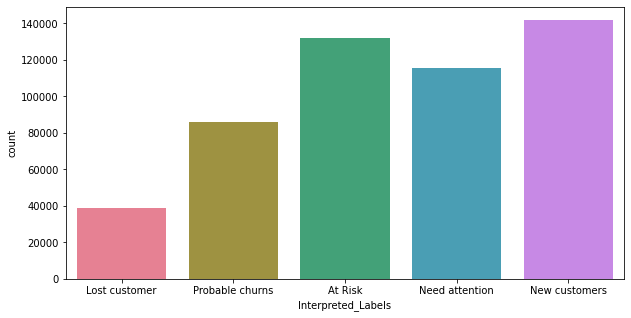

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Interpreted_Labels", data=data_process, palette="husl")

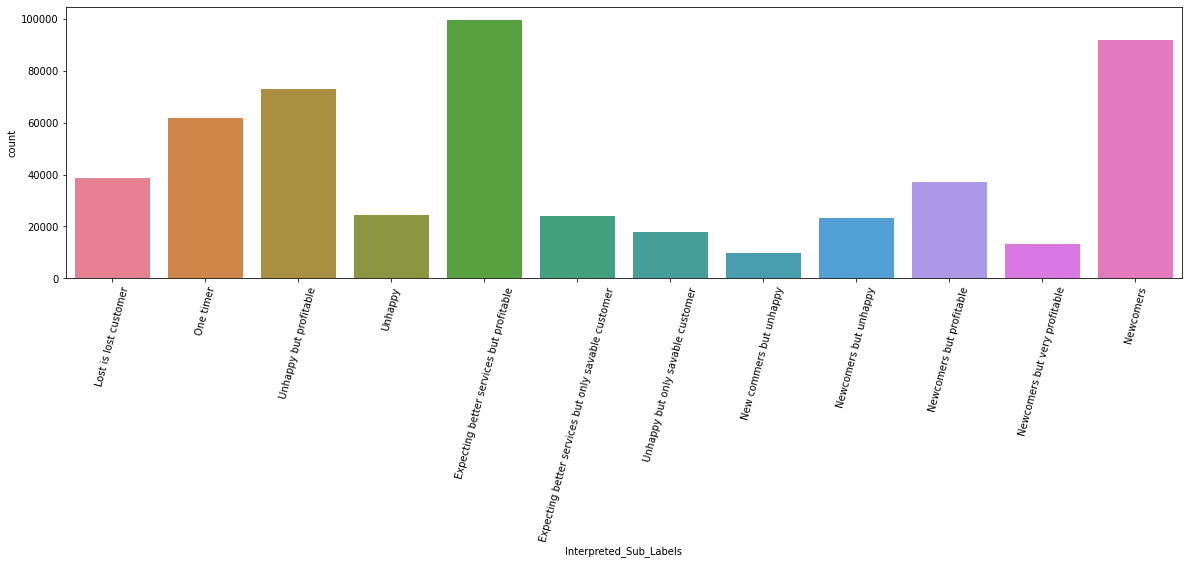

In [ ]:
plt.figure(figsize=(20, 5))
s = sns.countplot(x="Interpreted_Sub_Labels", data=data_process, palette="husl")
s.set_xticklabels(s.get_xticklabels(), rotation=75);

There will be a difference between customer segmentation on RFM score and RFM categories because the data has only type of Frequency value.

### Customer segmentation based on RFM score VS Customer segmenation based on RFM categories

In [ ]:
data_process.groupby(['Interpreted_Labels', 'Labels']).agg({'CustomerID': 'count'})

CustomerID
Interpreted_Labels Labels                     
At Risk            lost customer         17934
                   probable churns       20926
                   low                   25214
                   medium                26850
                   high                  41139
Lost customer      lost customer         38847
                   probable churns           0
                   low                       0
                   medium                    0
                   high                      0
Need attention     lost customer         18671
                   probable churns           0
                   low                   38586
                   medium                28635
                   high                  29978
New customers      lost customer             0
                   probable churns       56811
                   low                   34878
                   medium                36973
                   high                  13226
Probable churns    lost customer         45219
                   probable churns       20556
                   low                       0
                   medium                20297
                   high                      0

### Prepare data for Churn prediction

In [13]:
churn_data = trans_df[['CustomerID', 'GuestcheckId', 'channelId', 'CheckNo', 'TotalAmount', 'Transaction_date']].groupby('CustomerID').agg(
    { 
     'channelId': 'count',   
     'Transaction_date': 'max'}).reset_index()

churn_data.loc[churn_data.Transaction_date <= '2018-06-14', 'Data_type'] = 'train'
churn_data.loc[(churn_data.Transaction_date > '2018-06-14') & (churn_data.Transaction_date <= '2018-06-21'), 'Data_type'] = 'val'
churn_data.loc[churn_data.Transaction_date > '2018-06-21', 'Data_type'] = 'test'

churn_data.head(2)

,CustomerID,channelId,Transaction_date,Data_type
0,1,1,2018-05-15,train
1,2,1,2018-05-31,train


In [14]:
data_process = pd.read_csv('data/Customer_Segmentation_using_RFM.csv')
data_process['Churn'] = data_process.Labels.map({'lost customer': 'Yes', 
                                                 'probable churns': 'Yes', 
                                                 'low': 'No', 'medium': 'No', 'high': 'No'})
data_process.head(2)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_category,N_R_score,N_F_score,N_M_score,Weighted_RFM_score,Labels,Interpreted_Labels,Interpreted_Sub_Labels,Churn
0,1,47,1,374.32,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer,Lost customer,Lost is lost customer,Yes
1,2,31,1,427.99,1,1,2,4,112,0.2,1.0,0.4,0.42,lost customer,Lost customer,Lost is lost customer,Yes


In [15]:
churn_data = churn_data.merge(data_process[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churn']], on='CustomerID', how='inner')
churn_data.head(2)

,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn
0,1,1,2018-05-15,train,47,1,374.32,Yes
1,2,1,2018-05-31,train,31,1,427.99,Yes


In [16]:
churn_data.to_csv('data/churn_data.csv', index=False)

In [37]:
churn_data.head(10)

,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn
0,1,1,2018-05-15,train,47,1,374.32,Yes
1,2,1,2018-05-31,train,31,1,427.99,Yes
2,3,1,2018-05-31,train,31,1,59.86,Yes
3,4,1,2018-06-01,train,30,1,572.52,Yes
4,6,1,2018-06-01,train,30,1,387.78,Yes
5,7,1,2018-06-01,train,30,1,522.64,Yes
6,8,1,2018-06-01,train,30,1,474.04,Yes
7,9,1,2018-06-01,train,30,1,529.20,Yes
8,10,1,2018-06-01,train,30,1,229.51,Yes
9,11,1,2018-06-01,train,30,1,409.80,Yes


**IMPORTANTS**

- Considering 2018-06-30 as last date (reference date)